<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/old_playgrounds/SHADE_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai
!pip install nbdev

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import numpy as np
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from nbdev.showdoc import *
from fastai.vision.all import *
import torch.nn.functional as F
import torchvision.transforms.functional as FF
import numpy
import torchvision
from torchvision import *
import fastai
import fastcore
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bottleneck_ratio=4):
        super(BottleneckBlock, self).__init__()
        bottleneck_channels = out_channels // bottleneck_ratio

        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet12WithBottlenecks(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet12WithBottlenecks, self).__init__()
        self.in_channels = 64

        # First layer now accepts 3 input channels instead of 64
        self.layer1 = self._make_layer(64, 3, stride=1, input_channels=3)
        self.layer2 = self._make_layer(128, 3, stride=2)
        self.layer3 = self._make_layer(256, 3, stride=2)
        self.layer4 = self._make_layer(256, 3, stride=2)
        self.layer5 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, out_channels, blocks, stride, input_channels=None):
        layers = []

        # Set input channels for the first block of the first layer
        if input_channels:
            self.in_channels = input_channels

        layers.append(BottleneckBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BottleneckBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc2(x)


        return x


In [ ]:
#Load CIFAR-10 dataset from FastAI

path = untar_data(URLs.IMAGENETTE)
dls = ImageDataLoaders.from_folder(path, valid='val', bs=128, item_tfms=Resize(32), shuffle=True)

#Using Resnet18 not pre-trained as the model to work with CIFAR-10

modelo = ResNet12WithBottlenecks(num_classes=dls.c)
LEARN = Learner(dls, modelo, metrics=accuracy)

#LEARN.model.to('cuda')
#LEARN.dls.to('cuda')


In [ ]:
tabular_learner(layers=[16, 32, 64, 128, 256, 512, 1024, 2048,1024, 512, 256, 128, 64, 32, 16], dls=dls).summary()

AttributeError: cat_names

In [ ]:
import matplotlib.pyplot as plt

def plot_learners_training(learners, metric='loss'):
    """
    Plots the training and validation loss curves for an array of fastai learners.

    Parameters:
    - learners: list of fastai Learner objects
    - metric: 'loss' to plot loss curves (default), or 'metric' to plot a specific metric
    """
    plt.figure(figsize=(12, 6))
    max_epochs = max(len(learn.recorder.values) for learn in learners)
    for idx, learn in enumerate(learners):
        # Extract losses
        if metric == 'loss':
          train_losses = []
          val_losses = []
          accuracy = []
          for epoch in range(len(learn.recorder.values)):
            train_losses.append(learn.recorder.values[epoch][0])
            val_losses.append(learn.recorder.values[epoch][1])
            accuracy.append(learn.recorder.values[epoch][2])
            label_suffix = ''
        else:
            # Replace with the appropriate code if plotting other metrics
            raise ValueError(f"Metric '{metric}' is not supported in this function.")

        # Plot training loss
        plt.plot(train_losses, label=f'Learner {idx + 1} - Training Loss')
        # Plot validation loss
        plt.plot(val_losses, label=f'Learner {idx + 1} - Validation Loss', linestyle='--')
        # Plot accuracy
        plt.plot(accuracy, label=f'Learner {idx + 1} - Accuracy', linestyle='-.')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Accuracy, Training and Validation Loss for Multiple Learners')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, max_epochs-1)
    plt.show()



In [ ]:
LEARN.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.022425,1.834604,0.352102,01:09
1,1.758716,1.579339,0.468535,01:07
2,1.556010,1.421298,0.537070,01:07
3,1.393200,1.617450,0.483822,01:18
4,1.264518,1.297885,0.576815,01:08


In [ ]:
LEARN2.fit(10)

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,2.019862,1.876304,0.353631,01:09
1,1.750584,1.632779,0.448408,01:06
2,1.534833,1.484711,0.501911,01:07
3,1.373357,1.366834,0.546242,01:07
4,1.249721,1.309034,0.572484,01:09
5,1.165401,1.474159,0.530446,01:07
6,1.078026,1.113161,0.644076,01:08
7,1.009691,1.150280,0.624459,01:09
8,0.953707,1.127346,0.636688,01:07
9,0.903449,1.022959,0.668280,01:07


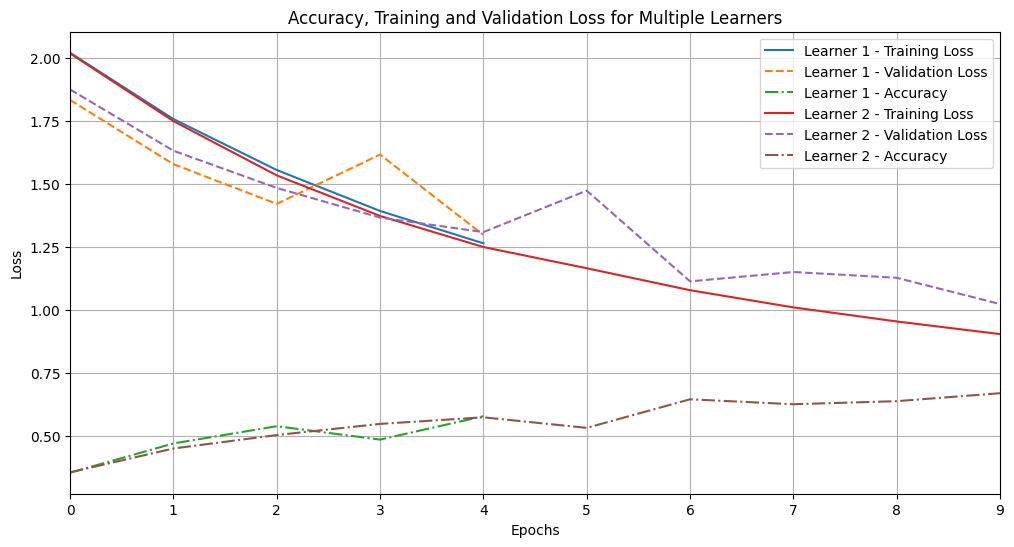

In [ ]:
plot_learners_training([LEARN, LEARN2])

In [ ]:
print(LEARN.recorder.values[0])

[1.3855714797973633, 1.3500562906265259, 0.4975999891757965]


In [ ]:
LEARN.summary()

ResNet12WithBottlenecks (Input shape: 128 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 32 x 32  
Conv2d                                    48         True      
BatchNorm2d                               32         True      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     128 x 64 x 32 x 32  
Conv2d                                    1024       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    192        True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 16 x 32 x 32  
Conv2d                 

In [ ]:

vision_learner(dls,resnet18, pretrained=False).summary()

Sequential (Input shape: 128 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 16 x 16  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 8 x 8    
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

In [ ]:
#Get params from a model in a numpy array

def get_params_from_model(model):
    return np.concatenate([v.cpu().detach().numpy().ravel() for v in model.parameters()])



#The params are set into the global model to compute the loss.
def set_params_to_model(params):
    offset = 0
    for param in LEARN.model.parameters():
        param_size = param.numel()
        param.data = torch.tensor(params[offset:offset + param_size], dtype=param.data.dtype).view(param.size())#.to('cuda')
        param.requires_grad = True
        offset += param_size

#Get the valid loss
def err_param_valid(params):
    set_params_to_model(params)

    LEARN.eval()
    #Option 1: calculate the error per each batch and make the mean

    loss =0.0

    #If i have categorical, continius and the target
    if len(dls.one_batch()) > 2:
      for batch in dls.valid:
        # Handle the case where there are no continuous features
        x_cont = batch[1] if len(batch) > 1 and batch[1] is not None else None
        pred = LEARN.model(batch[0], x_cont)  # Pass both categorical and continuous features (if any)
        pred = torch.tensor(pred.clone().detach())
        target = torch.tensor(batch[2].squeeze().long().clone().detach())
        loss += F.cross_entropy(pred, target)


    #If not
    else:
      for batch in dls.valid:
        # Handle the case where there are no continuous features

        pred = LEARN.model(batch[0])  # Pass both categorical and continuous features (if any)
        pred = torch.tensor(pred.clone().detach())
        target = torch.tensor(batch[1].squeeze().long().clone().detach())
        loss += F.cross_entropy(pred, target)

    loss/=len(dls.valid)


    return loss.mean().item()


#Get de train loss
def err_param(params):
    set_params_to_model(params)

    LEARN.train()
    #Option 1: calculate the error per each batch and make the mean

    loss =0.0

    #If i have categorical, continius and the target
    if len(dls.one_batch()) > 2:
      for batch in dls.train:
        # Handle the case where there are no continuous features
        x_cont = batch[1] if len(batch) > 1 and batch[1] is not None else None
        pred = LEARN.model(batch[0], x_cont)  # Pass both categorical and continuous features (if any)
        pred = torch.tensor(pred.clone().detach())
        target = torch.tensor(batch[2].squeeze().long().clone().detach())
        loss += F.cross_entropy(pred, target)


    #If not
    else:
      for batch in dls.train:
        # Handle the case where there are no continuous features

        pred = LEARN.model(batch[0])  # Pass both categorical and continuous features (if any)
        pred = torch.tensor(pred.clone().detach())
        target = torch.tensor(batch[1].squeeze().long().clone().detach())
        loss += F.cross_entropy(pred, target)

    loss/=len(dls.valid)


    return loss.mean().item()


def test_err_param(params, batch):
    set_params_to_model(params)

    LEARN.train()
    #Option 1: calculate the error per each batch and make the mean

    # Handle the case where there are no continuous features
    if len(batch) > 2:
      x_cont = batch[1] if len(batch) > 1 and batch[1] is not None else None
      pred = LEARN.model(batch[0], x_cont)  # Pass both categorical and continuous features (if any)
      pred = torch.tensor(pred.clone().detach())#.to('cuda')
      target = torch.tensor(batch[2].squeeze().long().clone().detach())#.to('cuda')

    else:
      pred = LEARN.model(batch[0])  # Pass both categorical and continuous features (if any)
      pred = torch.tensor(pred.clone().detach())#.to('cuda')
      target = torch.tensor(batch[1].squeeze().long().clone().detach())#.to('cuda')

    loss = F.cross_entropy(pred, target)



    return loss.mean().item()







In [ ]:
#!pip install ~/pyade-master
!pip install /content/drive/MyDrive/pyade-master
import pyade

Processing ./drive/MyDrive/pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29159 sha256=06fb218cac1d5f0757d6de7f0fb91ecbac2f7df0570b8ae31bcf9f1b61622298
  Stored in directory: /root/.cache/pip/wheels/89/b8/51/ff2ebef24405d3ef46ccb451f962b374b2745f263fb000c434
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [ ]:
import pyade.shade

algorithm = pyade.shade

def SHADE_ej(population, fitness, pop_size, max_evals, dim, dls, prevm_cr=0, prevm_f=0, k=0):

  population = np.array(population).reshape(pop_size, dim)
  fitness = np.array(fitness)

  params = algorithm.get_default_params(dim=dim)
  # We define the boundaries of the variables
  params['bounds'] = np.array([[-50, 50]] * dim)

  # We indicate the function we want to minimize
  params['func'] = test_err_param

  params['population_size']=pop_size



  params['seed']=42




  params['init_pop']=population

  params['max_evals']=max_evals


  params['prevm_cr']=prevm_cr

  params['prevm_f']=prevm_f

  params['k']=k

  params['fitness']=fitness
  params['dls']=dls

  return algorithm.apply(**params)






In [ ]:
import gc
gc.collect()

8

In [ ]:
population = [get_params_from_model(ResNet12WithBottlenecks(10)) for _ in range(10)]


He añadido un parametro de entrada y de salida k en la funcion de shade para ir pasandolo entre ejecuciones. Los recursos de RAM parece que se caban estabilizando asi que no hay mucho problema en cuanto a recursos, ya tendría que estar pendiente del tiempo.

In [ ]:
params = algorithm.get_default_params(dim=len(population[0]))
print(params['memory_size'])

100


- Tengo SHADE funcionando. Tengo que hace ILS-SHADE basicamente añadiendo la busqueda local y todo el rollo según el paper de dani molina.

- He cambiado el return del shade.py para que devuelva toda la poblacion, todo el vector de fitness y que ademas devuelva los parametros, y que se puedan volver a meter luego para que se siga adaptando. Solo guardo los parametros de las matrices porque son los que guardan los resultados exitosos de los valores, y los que se aprovechan luego en el resto de ejecuciones. Podría rentar meter la ejecucion de SHADE junto con el correspondiente guardado


- Tengo funcionando la Búsqueda local con L-BFGS-B. Tengo dos opciones: la implementación con pytorch y la implementación con scipy. La de scipy calcula el gradiente aproximado de un batch y hace bastantes iteraciones (unas 30) mientras que la otra la calcula en minibatches y aplica cambios tras cada mini-batch y solo hace un epoch.

- La de PyTorch en principio está más pensada para este tipo de optimizaciones de machine learning. Al principio funcionaba mucho mejor la de PyTorch pero ahora funciona mucho mejor la de ScipY

- Sería interesante y justificable usar solo esta búsqueda local en el algoritmo de SHADE-ILS ya que es un método conocido de segundo orden para entrenamiento de modelos.

- Cuando vaya a entrenar a resnet18 será complicado por el número de parámetros. Opciones varias son: meter menos búsqueda local en ese momento, buscar un modelo más pequeño, buscar una búsqueda local más accesible, o, en última opción: no hacer SHADE-ILS con resnet18. He probado con el MLP de 15 capas y no tarda demasiado obteniendo resultados aceptables de 0.17 (3 min)

- Ejecucion de SHADE-ILS con MLP 15 capas: 14 min

- Aun asi puedo investigar un poco el otro tipo de BL: MTS LS

# TODO

2. (Opcional) AÑADIR metodo MTS LS. En tal caso tengo que añadir también el criterio para que se aplique o no la LS y cual se aplica.

3. FINE-TUNE de parámetros: evaluaciones, num_pob, etc

4. REDACTAR la experimentacion detalladamente y enviarsela a pablo.

5. PENSAR qué métricas, datos voy a medir y a comparar.

6. COMPROBAR cálculo del gradiente y función de error.

7. (OPCIONAL) COMPROBAR qué pasa usando la función f\_min\_fbgs de minimize de scipy: es en esencia la misma función que la que estoy usando ahora pero no usa ninguna función gradiente: lo hace a través de una aproximación por diferencias finitas. Intuición de lo que va a pasar: si uso minimize() sin pasarle la función gradiente para la aproximación tarda una eternidad (para de 1seg a más de 4min para 32 neuronas)

In [ ]:
#BUSQUEDA LOCAL CON LBFGS CON LIBRERIA SCIPY
from scipy.optimize import minimize
def get_gradient(ind):
    set_params_to_model(ind)
    LEARN.train()  # Put the model in training mode
    batch = dls.train.one_batch()

    pred = LEARN.model(batch[0])  # Make predictions
    # Convert predictions and targets to torch.Tensor subclass
    pred = pred.as_subclass(torch.Tensor).clone()
    target = batch[1].squeeze().long().as_subclass(torch.Tensor).clone()

    # Calculate the loss using cross_entropy
    loss = F.cross_entropy(pred, target)
    loss.backward()  # Calculate gradients

    # Extract gradients into a list
    gradients = [param.grad.clone().detach().cpu().numpy().ravel() for param in LEARN.model.parameters()]

    # Concatenate gradients into a single 1D array
    return loss.mean().item(), np.concatenate(gradients)

def LBFGS_SCIPY(ind):
    result = minimize(get_gradient, ind, jac=True, method='L-BFGS-B')
    return result.x, result.fun, result.nfev, result.njev


In [ ]:
result = minimize(get_gradient, ind, jac=True, method='L-BFGS-B')

In [ ]:
print(err_param(ind)) #2min

<ipython-input-72-5410764ad5d9>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred.clone().detach())
<ipython-input-72-5410764ad5d9>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch[1].squeeze().long().clone().detach())


2.5692601203918457


In [ ]:
import torch.optim as optim
layers=[64, 32, 8]
LEARN =  tabular_learner(dls, layers=layers)



def epoch_LBFGS(ind):
    optimizer = optim.LBFGS(LEARN.model.parameters(), lr=0.01)
    set_params_to_model(ind)
    LEARN.train()  # Put the model in training mode


    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        batch = next(iter(dls.train))  # Get one batch of data
        # Handle the case where there are no continuous features
        x_cont = batch[1] if len(batch) > 1 and batch[1] is not None else None
        output = LEARN.model(batch[0], x_cont)  # Forward pass
        target = batch[2].squeeze().long()
        loss = F.cross_entropy(output, target)  # Accumulate loss
        loss.backward()  # Backward pass after accumulating loss over all batches
        return loss

    for _ in range(len(dls.train)): # Assuming you want to run for one epoch
        optimizer.step(closure)
        print("EO")

    return get_params_from_model(LEARN)

ind=get_params_from_model(LEARN)
print(err_param(ind))
ind = epoch_LBFGS(ind)
print(err_param(ind))

In [ ]:
max_evals = len(dls.train)*20*10
print(max_evals)

14600


In [ ]:
len(dls.valid)

79

In [ ]:
#batch = dls.train.one_batch()
#population = [get_params_from_model(ResNet12WithBottlenecks(num_classes=10)) for _ in range(10)]
#fitness = [test_err_param(elem, batch) for elem in population]

res = SHADE_ej(population, fitness, 10, 100, len(population[0]), dls, res[2], res[3], res[4])

<ipython-input-3-5410764ad5d9>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred.clone().detach())#.to('cuda')
<ipython-input-3-5410764ad5d9>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch[1].squeeze().long().clone().detach())#.to('cuda')


In [ ]:
res[1]

array([2.45542264, 2.45287633, 2.40922809, 2.48893261, 2.43574905,
       2.5562706 , 2.43299413, 2.42248034, 2.4516921 , 2.44551945])

In [ ]:
len(dls.valid)

31

In [ ]:
#Algoritmo SHADE-ILS
from collections import deque
#layers=[1024, 1024,512, 512, 256, 256, 128, 128, 64, 64, 32, 32, 8, 8, 4]
layers=[32]

#layers=[32]


population_size = 10
evals = 0
epochs= 20
max_evals = len(dls.train)*20
max_evals_SHADE = 250
prevm_cr=0
prevm_f=0
must_restart=False
improq = deque([1,1,1], maxlen=3)
batch = dls.train.one_batch()

#Initialize the population
population = [get_params_from_model(ResNet12WithBottlenecks(num_classes=10)) for _ in range(population_size)]
fitness = [err_param_valid(elem) for elem in population]
evals += population_size
size_ind=len(population[0])

#Select the best
current_best_index = fitness.index(np.min(fitness))
current_best_fitness = population[current_best_index]
current_best = population[current_best_index]

temp_current_best, temp_current_best_fitness, e1, e2 = LBFGS_SCIPY(current_best)
evals += e1 + e2 +1

temp_current_best_fitness = err_param_valid(temp_current_best)
improq.append((current_best_fitness-temp_current_best_fitness)/current_best_fitness)

if temp_current_best_fitness < current_best_fitness:
  current_best_fitness = temp_current_best_fitness
  current_best = temp_current_best


population[current_best_index] = current_best
fitness[current_best_index] = current_best_fitness

best_solution=current_best
best_fitness=current_best_fitness
k=0
while evals < max_evals:
  print("eo")
  population, fitness, prevm_cr, prevm_f, k = SHADE_ej(population, fitness, population_size, max_evals_SHADE, size_ind, dls, prevm_cr=prevm_cr, prevm_f=prevm_f,k=k)
  evals += max_evals_SHADE + 1

  fitness = [err_param_valid(ind) for ind in population]
  temp_current_best_fitness = np.min(fitness)
  temp_current_best_index = fitness.index(temp_current_best_fitness)
  temp_current_best = population[temp_current_best_index]


  improq.append((current_best_fitness-temp_current_best_fitness)/current_best_fitness)

  current_best_fitness = temp_current_best_fitness
  current_best_index = temp_current_best_index
  current_best = temp_current_best



  print(improq)
  if np.all(np.array(improq)<0.05):
    must_restart=True

  #Choose the LS method to apply this iteration based on improvement

  temp_current_best, temp_current_best_fitness, e1, e2 = LBFGS_SCIPY(current_best)
  evals += e1 + e2 +1

  temp_current_best_fitness = err_param_valid(temp_current_best)
  improq.append((current_best_fitness-temp_current_best_fitness)/current_best_fitness)

  current_best_fitness = temp_current_best_fitness
  current_best = temp_current_best


  print(improq)
  if np.all(np.array(improq)<0.05):
    must_restart=True

  population[current_best_index] = current_best
  fitness[current_best_index] = current_best_fitness

  #Update the probability to apply LS in next iterations

  if current_best_fitness < best_fitness:
    best_fitness = np.copy(current_best_fitness)
    best_solution = np.copy(current_best)

  if must_restart:
    random_index = np.random.choice(population_size)
    sol = population[random_index]
    sol += np.random.normal(0, 0.02, len(sol))

    population = [get_params_from_model(ResNet12WithBottlenecks(num_classes=10)) for _ in range(population_size-1)]
    k=0
    prevm_cr=0
    prevm_f=0
    batch = dls.train.one_batch()
    fitness = [err_param_valid(elem) for elem in population]
    evals += population_size+1
    population.append(sol)
    current_best_fitness=err_param_valid(sol)
    current_best=sol
    fitness.append(current_best_fitness)
    improq=deque([1,1,1], maxlen=3)

    print("Reiniciado")
    must_restart=False


NameError: name 'dls' is not defined

In [ ]:
print(evals)

3039


list

Tengo que ver como hago lo de las epochs. Dos opciones: muchas iteraciones totales (nepochxnbatchesxnpob) con la funcion de error que calcule solo el error de un batch (esto tiene problemas a la hora de la comparacion y de implementar pq tengo q arrastrar mucho.

O bien hago una funcion de eval que evalúe todo el batch con menos epochs (aun asi aquí 400 evaluaciones serían unas 6 horas)

Idea: puedo usar el error batch entero en SHADE, usar el parcial en LBFGS y me como 20~40 iteraciones del tiron, y luego al final lo vuelvo a calcular con todo el batch.